In [2]:
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [3]:
import kagglehub

print("=" * 50)
print("ZOMATO DATA CLEANING PROJECT (Kaggle-sourced)")
print("=" * 50)

path = kagglehub.dataset_download("himanshupoddar/zomato-bangalore-restaurants")
print("Path to dataset files:", path)

candidate_csvs = []
for pattern in ["**/zomato.csv", "**/Zomato.csv", "**/*zomato*bangalore*.csv", "**/*zomato*.csv"]:
    candidate_csvs.extend(glob.glob(os.path.join(path, pattern), recursive=True))

if not candidate_csvs:
    raise FileNotFoundError("Could not find zomato CSV in the Kaggle download directory. Please inspect 'path' and list files.")

csv_path = sorted(candidate_csvs, key=len)[0]
print(f"Using CSV file: {csv_path}")

# Load the dataset
df = pd.read_csv(csv_path, encoding="utf-8")

c:\Users\veerk\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ZOMATO DATA CLEANING PROJECT (Kaggle-sourced)
Path to dataset files: C:\Users\veerk\.cache\kagglehub\datasets\himanshupoddar\zomato-bangalore-restaurants\versions\1
Using CSV file: C:\Users\veerk\.cache\kagglehub\datasets\himanshupoddar\zomato-bangalore-restaurants\versions\1\zomato.csv


In [4]:
# 1. INITIAL DATA EXPLORATION
print("\n1. INITIAL DATA EXPLORATION")
print("=" * 30)
print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst 5 rows:")
print(df.head())
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())


1. INITIAL DATA EXPLORATION
Dataset Shape: (51717, 17)
Columns: ['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes', 'phone', 'location', 'rest_type', 'dish_liked', 'cuisines', 'approx_cost(for two people)', 'reviews_list', 'menu_item', 'listed_in(type)', 'listed_in(city)']

First 5 rows:
                                                 url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stag

In [7]:
# 2. HANDLE MISSING VALUES
print("\n2. HANDLING MISSING VALUES")
print("=" * 30)

# Report missing percentages
missing_percent = (df.isnull().sum() / len(df)) * 100
print("Missing values percentage:")
print(missing_percent)

# Helper: clean numeric-like strings (e.g., "2,500") to floats
def _to_numeric_series(s):
    s = s.astype(str).str.strip()
    s = s.replace(['', 'nan', 'None', 'NaN'], np.nan)
    s = s.str.replace(',', '', regex=False)
    return pd.to_numeric(s, errors='coerce')

# rate: keep original text for reference; impute missing with a neutral token
if 'rate' in df.columns:
    df['rate'] = df['rate'].fillna('0 out of 5')

# approx_cost(for two people): convert to numeric safely, then median-impute
cost_col = 'approx_cost(for two people)'
if cost_col in df.columns:
    df[cost_col] = _to_numeric_series(df[cost_col])
    if df[cost_col].notna().any():
        df[cost_col] = df[cost_col].fillna(df[cost_col].median())
    else:
        # if column is entirely non-numeric/unavailable, default to 0
        df[cost_col] = df[cost_col].fillna(0.0)

# cuisines and dish_liked: fill with informative placeholders
if 'cuisines' in df.columns:
    df['cuisines'] = df['cuisines'].fillna('Unknown')
if 'dish_liked' in df.columns:
    df['dish_liked'] = df['dish_liked'].fillna('Not Specified')

# Drop columns with >50% missing
threshold = int(len(df) * 0.5)
df_cleaned = df.dropna(axis=1, thresh=threshold)

print(f"Shape after handling missing values: {df_cleaned.shape}")
print("Remaining missing values:")
print(df_cleaned.isnull().sum())



2. HANDLING MISSING VALUES
Missing values percentage:
url                             0.000000
address                         0.000000
name                            0.000000
online_order                    0.000000
book_table                      0.000000
rate                            0.000000
votes                           0.000000
phone                           2.335789
location                        0.040606
rest_type                       0.438927
dish_liked                     54.291626
cuisines                        0.087012
approx_cost(for two people)     0.669026
reviews_list                    0.000000
menu_item                       0.000000
listed_in(type)                 0.000000
listed_in(city)                 0.000000
dtype: float64
Shape after handling missing values: (51717, 17)
Remaining missing values:
url                               0
address                           0
name                              0
online_order                      0
book_table    

In [8]:
# 3. REMOVE DUPLICATES
print("\n3. REMOVING DUPLICATES")
print("=" * 30)
initial_rows = len(df_cleaned)
df_cleaned = df_cleaned.drop_duplicates()
final_rows = len(df_cleaned)
duplicates_removed = initial_rows - final_rows
print(f"Duplicates removed: {duplicates_removed}")
print(f"Shape after removing duplicates: {df_cleaned.shape}")


3. REMOVING DUPLICATES
Duplicates removed: 0
Shape after removing duplicates: (51717, 17)


In [10]:
# 4. STANDARDIZE TEXT COLUMNS
print("\n4. STANDARDIZING TEXT COLUMNS")
print("=" * 30)
def clean_text_columns(df_in):
    df_out = df_in.copy()
    if 'name' in df_out.columns:
        df_out['name'] = df_out['name'].astype(str).str.strip().str.title()
    if 'location' in df_out.columns:
        df_out['location'] = df_out['location'].astype(str).str.strip().str.title()
    if 'rest_type' in df_out.columns:
        df_out['rest_type'] = df_out['rest_type'].astype(str).str.strip().str.title()
    if 'cuisines' in df_out.columns:
        df_out['cuisines'] = df_out['cuisines'].astype(str).str.strip().str.title()
    return df_out

df_cleaned = clean_text_columns(df_cleaned)
print("Sample cleaned text columns:")
print(df_cleaned[['name', 'location', 'rest_type', 'cuisines']].head())


4. STANDARDIZING TEXT COLUMNS
Sample cleaned text columns:
                    name      location            rest_type  \
0                  Jalsa  Banashankari        Casual Dining   
1         Spice Elephant  Banashankari        Casual Dining   
2        San Churro Cafe  Banashankari  Cafe, Casual Dining   
3  Addhuri Udupi Bhojana  Banashankari          Quick Bites   
4          Grand Village  Basavanagudi        Casual Dining   

                         cuisines  
0  North Indian, Mughlai, Chinese  
1     Chinese, North Indian, Thai  
2          Cafe, Mexican, Italian  
3      South Indian, North Indian  
4        North Indian, Rajasthani  


In [12]:
# 5. CORRECT DATA TYPES
print("\n5. CORRECTING DATA TYPES")
print("=" * 30)
def correct_data_types(df_in):
    df_out = df_in.copy()
    if 'rate' in df_out.columns:
        def clean_rate(rate):
            if isinstance(rate, str):
                match = re.search(r'(\d+\.?\d*)', str(rate))
                if match:
                    return float(match.group(1))
            return np.nan
        df_out['rate_clean'] = df_out['rate'].apply(clean_rate)
        df_out['rate_clean'] = df_out['rate_clean'].fillna(df_out['rate_clean'].median())
    if 'approx_cost(for two people)' in df_out.columns:
        def clean_cost(cost):
            if pd.isna(cost):
                return np.nan
            if isinstance(cost, str):
                return float(cost.replace(',', '').strip())
            return float(cost)
        df_out['cost_for_two'] = df_out['approx_cost(for two people)'].apply(clean_cost)
        df_out['cost_for_two'] = df_out['cost_for_two'].fillna(df_out['cost_for_two'].median())
    return df_out

df_cleaned = correct_data_types(df_cleaned)
print("Sample of corrected numeric columns:")
print(df_cleaned[['rate', 'rate_clean', 'approx_cost(for two people)', 'cost_for_two']].head())


5. CORRECTING DATA TYPES
Sample of corrected numeric columns:
    rate  rate_clean  approx_cost(for two people)  cost_for_two
0  4.1/5         4.1                        800.0         800.0
1  4.1/5         4.1                        800.0         800.0
2  3.8/5         3.8                        800.0         800.0
3  3.7/5         3.7                        300.0         300.0
4  3.8/5         3.8                        600.0         600.0


In [13]:
# 6. HANDLE OUTLIERS
print("\n6. HANDLING OUTLIERS")
print("=" * 30)
def handle_outliers(df_in):
    df_out = df_in.copy()
    numerical_cols = []
    if 'rate_clean' in df_out.columns:
        numerical_cols.append('rate_clean')
    if 'cost_for_two' in df_out.columns:
        numerical_cols.append('cost_for_two')
    for col in numerical_cols:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df_out[(df_out[col] < lower_bound) | (df_out[col] > upper_bound)]
        print(f"Outliers in {col}: {len(outliers)}")
        df_out[col] = np.where(df_out[col] < lower_bound, lower_bound, df_out[col])
        df_out[col] = np.where(df_out[col] > upper_bound, upper_bound, df_out[col])
    return df_out

df_cleaned = handle_outliers(df_cleaned)
print("Sample after handling outliers:")
print(df_cleaned[['rate_clean', 'cost_for_two']].head())



6. HANDLING OUTLIERS
Outliers in rate_clean: 7815
Outliers in cost_for_two: 4764
Sample after handling outliers:
   rate_clean  cost_for_two
0         4.1         800.0
1         4.1         800.0
2         3.8         800.0
3         3.7         300.0
4         3.8         600.0


In [14]:
# 7. FEATURE ENGINEERING
print("\n7. FEATURE ENGINEERING")
print("=" * 30)
def create_new_features(df_in):
    df_out = df_in.copy()
    if 'cuisines' in df_out.columns:
        df_out['num_cuisines'] = df_out['cuisines'].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)
    if 'cost_for_two' in df_out.columns:
        df_out['cost_category'] = pd.cut(
            df_out['cost_for_two'],
            bins=[0, 500, 1000, 2000, float('inf')],
            labels=['Budget', 'Moderate', 'Expensive', 'Premium'],
            include_lowest=True
        )
    if 'rate_clean' in df_out.columns:
        df_out['rating_category'] = pd.cut(
            df_out['rate_clean'],
            bins=[0, 2, 3, 4, 5],
            labels=['Poor', 'Average', 'Good', 'Excellent'],
            include_lowest=True
        )
    return df_out

df_cleaned = create_new_features(df_cleaned)
print("Sample of new features:")
print(df_cleaned[['num_cuisines', 'cost_category', 'rating_category']].head())



7. FEATURE ENGINEERING
Sample of new features:
   num_cuisines cost_category rating_category
0             3      Moderate       Excellent
1             3      Moderate       Excellent
2             3      Moderate            Good
3             2        Budget            Good
4             2      Moderate            Good


In [15]:
# 8. FINAL DATA QUALITY CHECK
print("\n8. FINAL DATA QUALITY CHECK")
print("=" * 30)
print(f"Final Dataset Shape: {df_cleaned.shape}")
print(f"Final Data Types:\n{df_cleaned.dtypes}")
print(f"Remaining Missing Values:\n{df_cleaned.isnull().sum()}")

numerical_summary = df_cleaned[['rate_clean', 'cost_for_two', 'num_cuisines']].describe() if all(
    col in df_cleaned.columns for col in ['rate_clean', 'cost_for_two', 'num_cuisines']) else pd.DataFrame()
print(f"\nNumerical Columns Summary:\n{numerical_summary}")


8. FINAL DATA QUALITY CHECK
Final Dataset Shape: (51717, 22)
Final Data Types:
url                              object
address                          object
name                             object
online_order                     object
book_table                       object
rate                             object
votes                             int64
phone                            object
location                         object
rest_type                        object
dish_liked                       object
cuisines                         object
approx_cost(for two people)     float64
reviews_list                     object
menu_item                        object
listed_in(type)                  object
listed_in(city)                  object
rate_clean                      float64
cost_for_two                    float64
num_cuisines                      int64
cost_category                  category
rating_category                category
dtype: object
Remaining Missing Values:



9. DATA VISUALIZATION


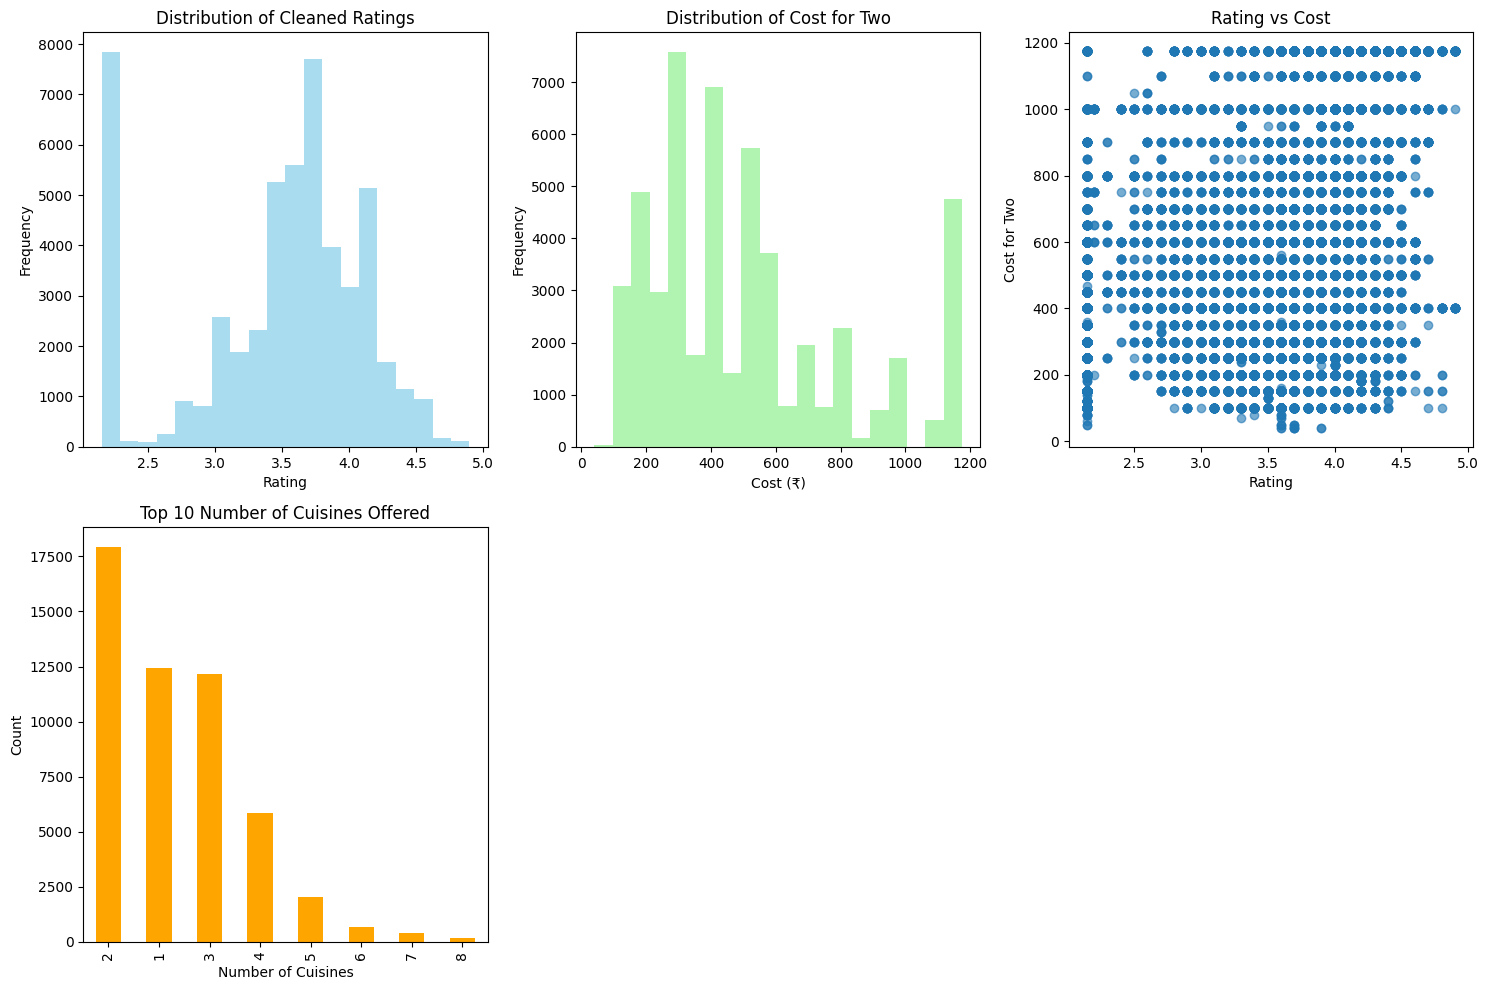

In [16]:
# 9. VISUALIZATION
print("\n9. DATA VISUALIZATION")
print("=" * 30)
plt.figure(figsize=(15, 10))

if 'rate_clean' in df_cleaned.columns:
    plt.subplot(2, 3, 1)
    plt.hist(df_cleaned['rate_clean'], bins=20, alpha=0.7, color='skyblue')
    plt.title('Distribution of Cleaned Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')

if 'cost_for_two' in df_cleaned.columns:
    plt.subplot(2, 3, 2)
    plt.hist(df_cleaned['cost_for_two'], bins=20, alpha=0.7, color='lightgreen')
    plt.title('Distribution of Cost for Two')
    plt.xlabel('Cost (₹)')
    plt.ylabel('Frequency')

if all(col in df_cleaned.columns for col in ['rate_clean', 'cost_for_two']):
    plt.subplot(2, 3, 3)
    plt.scatter(df_cleaned['rate_clean'], df_cleaned['cost_for_two'], alpha=0.6)
    plt.title('Rating vs Cost')
    plt.xlabel('Rating')
    plt.ylabel('Cost for Two')

if 'num_cuisines' in df_cleaned.columns:
    plt.subplot(2, 3, 4)
    df_cleaned['num_cuisines'].value_counts().head(10).plot(kind='bar', color='orange')
    plt.title('Top 10 Number of Cuisines Offered')
    plt.xlabel('Number of Cuisines')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [18]:
# 10. SAVE CLEANED DATASET
print("\n10. SAVING CLEANED DATASET")
print("=" * 30)
out_csv = os.path.join(os.path.dirname(csv_path), "zomato_cleaned.csv")
df_cleaned.to_csv(out_csv, index=False)
print(f"Cleaned dataset saved as '{out_csv}'")
print("Data cleaning process completed successfully.")


10. SAVING CLEANED DATASET
Cleaned dataset saved as 'C:\Users\veerk\.cache\kagglehub\datasets\himanshupoddar\zomato-bangalore-restaurants\versions\1\zomato_cleaned.csv'
Data cleaning process completed successfully.


In [19]:
# FINAL SUMMARY
print("\n" + "=" * 50)
print("CLEANING PROCESS SUMMARY")
print("=" * 50)
print(f"Original shape: {df.shape}")
print(f"Final shape: {df_cleaned.shape}")
print(f"Columns processed: {len(df_cleaned.columns)}")
print(f"Missing values handled: ✓")
print(f"Duplicates removed: {duplicates_removed}")
print(f"Data types corrected: ✓")
print(f"Outliers handled: ✓")
print(f"New features created: ✓")
print("Dataset ready for analysis!")


CLEANING PROCESS SUMMARY
Original shape: (51717, 17)
Final shape: (51717, 22)
Columns processed: 22
Missing values handled: ✓
Duplicates removed: 0
Data types corrected: ✓
Outliers handled: ✓
New features created: ✓
Dataset ready for analysis!
